 # Diffusion Demo <img src="LOGO-GliMR.png" align="right" height="100" width="100" >


### Loading data

Let's start by loading some dMRI data using Dipy [dipy.org](https://dipy.org/) This dataset was kindly provided by Hansen and Jespersen [Hansen2016](https://www.nature.com/articles/sdata201672) and has already been corrected for [eddy-current distortions](https://dipy.org/documentation/1.3.0./data/).

In [1]:
import dipy
from dipy.data import get_fnames
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

The downloaded data contains four files: 1) a NIFTI file containing dMRI data; 2) b-values list; 3) diffusion gradient directions (b-vectors); 4) T1-weighted structural NIFTI image.

Below we print their paths:

In [2]:
print(fraw)
print(fbval)
print(fbvec)
print(t1_fname)

/home/rgnunes/.dipy/cfin_multib/__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.nii
/home/rgnunes/.dipy/cfin_multib/__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.bval
/home/rgnunes/.dipy/cfin_multib/__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.bvec
/home/rgnunes/.dipy/cfin_multib/T1.nii


**Note:** Like many other tools, Dipy handles dMRI data in the NIFTI format. If your data is in DICOM format, you need to convert them to NIFTI using for example [dicom2nifti](https://pypi.org/project/dicom2nifti/)

### Reading data

1) To read the dMRI data we use Dipy's function "load_nifti"

In [3]:
from dipy.io.image import load_nifti

data, affine = load_nifti(fraw)

2) To read the b-values and b-vectors we use Dipy's function "read_bvals_bvecs"

In [4]:
from dipy.io.gradients import read_bvals_bvecs

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

To have a sense of the raw dMRI images let's inspect the data:

In [5]:
print("The shape of variable data is {}".format(data.shape))

The shape of variable data is (96, 96, 19, 496)


dMRI data typically corresponds to a 4D matrix: three dimensions correspond to the voxel coordinates while the last coordinate corresponds to the number of diffusion-weighted volumes (496 in this case). 

Let's visualize the middle axial slice of the 158th dMRI volume.

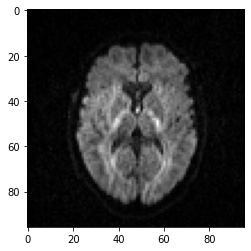

In [6]:
import matplotlib.pyplot as plt
import numpy as np

mid_sli = 9
exp_ind = 157
# Python indexing starts from 0 so the 158th experiment corresponds to index 157

# rotating the image 
plt.imshow(np.rot90(data[:, :, mid_sli, exp_ind]), cmap='gray')

The variable bvals contains the b-values of each dMRI volume and thus its length corresponds to the the last dimension of the dMRI data.

In [7]:
print("The shape of variable bvals is {}".format(bvals.shape))

The shape of variable bvals is (496,)


Regarding the variable bvecs, this is a 496 $\times$ 3 matrix corresponding to the 3 coordinates of the gradient directions of all 496 experiments: 

In [8]:
print("The shape of variable bvecs is {}".format(bvecs.shape))

The shape of variable bvecs is (496, 3)


Below we print the b-value and diffusion gradient direction used for the 158th dMRI experiment

In [9]:
print("158th experiment was acquired with b-value={} s/mm^2".format(bvals[exp_ind]))
print("158th experiment was acquired with b-vector={}".format(bvecs[exp_ind, :]))

158th experiment was acquired with b-value=1000.0 s/mm^2
158th experiment was acquired with b-vector=[ 0.999054  -0.037643  -0.0217622]


### Creating the GradientTable Object

In DIPY, an object called "GradientTable" is used to summarize the diffusion acquisition parameters (b-values, b-vectors, and others if specified).

In [10]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

The "gtab" object can be useful to quickly inspect information about the acquisition parameters. For example, the object attribute "b0s_mask" retrieves a boolean array in which elements with True value indicates the experiments acquired by b-value=0.

In [11]:
print(gtab.b0s_mask)

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

The b-values and b-vectors are also stored in the attributes gtab.bvals and gtab.bvecs respectively.

Below we print again the b-value and b-vector of the 158th volume using the "gtab" attributes

In [12]:
print("158th volume was acquired with b-value={} s/mm^2".format(gtab.bvals[exp_ind]))
print("158th volume was acquired with b-vector={}".format(gtab.bvecs[exp_ind, :]))

158th volume was acquired with b-value=1000.0 s/mm^2
158th volume was acquired with b-vector=[ 0.999054  -0.037643  -0.0217622]


Now that we are familiarized with the dMRI data format, we can for example:

1) Use gtab.b0s_mask to select the dMRI data acquired with b-value=0.

2) Plot the middle slice of the selected data, together with the middle slices of the data acquired of experiments 154, 158, 484, 488.

3) Print the b-values and b-vectors of experiments 154, 158, 484, 488.


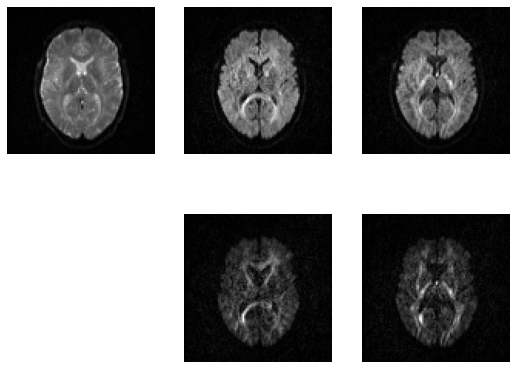

b-value = [1000. 1000. 3000. 3000.] s/mm^2
b-vectors = [[ 0.443994  -0.111793   0.889028 ]
 [ 0.999054  -0.037643  -0.0217622]
 [ 0.443656  -0.109618   0.889468 ]
 [ 0.999069  -0.0357358 -0.0241859]] 


In [13]:
# Select data acquired with b-value = 0
S0 = np.mean(data[..., gtab.b0s_mask], axis=-1)

# Plot middle slice data
plt.figure(figsize=(9, 7))

plt.subplot(2, 3, 1).set_axis_off()
plt.imshow(np.rot90(S0[..., mid_sli]), cmap='gray')

plt.subplot(2, 3, 2).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 153]), cmap='gray')

plt.subplot(2, 3, 3).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 157]), cmap='gray')

plt.subplot(2, 3, 5).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 483]), cmap='gray')

plt.subplot(2, 3, 6).set_axis_off()
plt.imshow(np.rot90(data[..., mid_sli, 487]), cmap='gray')

plt.show()

# print b-values and b-vectors
inds = [153, 157, 483, 487]
print("b-value = {} s/mm^2".format(gtab.bvals[inds]))
print("b-vectors = {} ".format(gtab.bvecs[inds]))

### Computing the ADC map

dMRI images depend also on the tissue relaxation times ($S=S_0 exp(-bD_{app})$). To extract the diffusion information, you can calculate the apparent diffusion coefficient (ADC) for each experiment using the following formula:

$$D_{app} = -\frac{1}{b}\log{(\frac{S}{S_0})} $$

Let's start by:

1) computing the ADC for all 496 dMRI experiments.

2) plot the ADC for experiments 154, 158, 484, 488.

*Note: The calculation of 𝐷𝑎𝑝𝑝 involves the division of S0 signals. In particular in the background, the division may generate infinite values. For plotting proposes, a simple brain mask can be computed using the "median_otsu" function from “dipy.segment.mask” 

In [14]:
# Extracting a simple brain mask
from dipy.segment.mask import median_otsu

mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1)[1]

An alternative could be to use FSL's bet to carry out brain extraction.

*Note: This option is commented out as it would only work if running the Jupyter notebook locally.

In [15]:
# from dipy.io.image import load_nifti
# from dipy.io.image import save_nifti

# save_nifti('b0.nii.gz', S0.astype(np.float32), affine)

# !bet b0 b0brain -R -Z -m

# mask_bet, affine = load_nifti('b0brain_mask.nii.gz')


<ipython-input-16-11989dc886b7>:6: RuntimeWarning: divide by zero encountered in true_divide
  Dapp[..., vi] = - np.log(data[..., sel_exp[vi]] / S0) / b
<ipython-input-16-11989dc886b7>:6: RuntimeWarning: invalid value encountered in true_divide
  Dapp[..., vi] = - np.log(data[..., sel_exp[vi]] / S0) / b
<ipython-input-16-11989dc886b7>:6: RuntimeWarning: divide by zero encountered in log
  Dapp[..., vi] = - np.log(data[..., sel_exp[vi]] / S0) / b


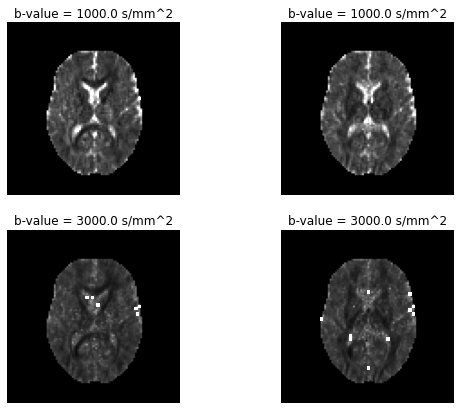

In [16]:
sel_exp=[153, 157, 483, 487]
Dapp = np.empty((96,96,19,4))
                 
for vi in range(0, len(sel_exp)):
    b = gtab.bvals[sel_exp[vi]]    
    Dapp[..., vi] = - np.log(data[..., sel_exp[vi]] / S0) / b
    Dapp[mask==0, vi] = 0       

# Plot middle slice data
plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 0]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[153]))

plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 1]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[157]))

plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 2]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[483]))

plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(np.rot90(Dapp[..., mid_sli, 3]), cmap='gray', vmin=0, vmax=3e-3)
plt.title("b-value = {} s/mm^2".format(gtab.bvals[487]))

plt.show()

# Diffusion Tensor Imaging

The information captured by dMRI is multi-dimensional. Diffusion tensor imaging (DTI), a pioneering dMRI technique, was proposed to quantify diffusion anisotropy ([Basser et al. 1994](https://pubmed.ncbi.nlm.nih.gov/8130344/)).

Instead of the constant scalar ADC, DTI represents diffusion at each voxel using the second order diffusion tensor:

$$\mathbf{D} = \begin{bmatrix} D_{xx} & D_{xy} & D_{xz} \\ D_{yx} & D_{yy} & D_{yz} \\ D_{zx} & D_{zy} & D_{zz} \end{bmatrix} $$

This tensor can be geometrically represented by an ellipsoid, and provides valuable information on diffusion anisotropy. As it is symmetric, only 6 free parameters ($D_{xx}$, $D_{yy}$, $D_{zz}$, $D_{xy}$, $D_{xz}$, $D_{yz}$) need to be estimated when using this signal model:

$$S ( \mathbf{n}, b) = S_0 exp(-b \mathbf{n}^T \mathbf{D} \mathbf{n})$$ 

where $\mathbf{n}$ is the gradient direction.

Let's see how to apply the DTI model within Dipy [dipy.org](https://dipy.org/).

In [17]:
import dipy.reconst.dti as dti

### Selecting a subset of b-values

For this example, let's select only the b-values up to 1000 s/mm².

In [18]:
bval_mask = bvals <= 1000 
gtab_cropped = gradient_table(bvals[bval_mask], bvecs[bval_mask, :], b0_threshold=0)

Let's print the b-values and b-vectors of this dataset

In [19]:
print("b-value = {} s/mm^2".format(gtab_cropped.bvals))
print("b-vectors = {} ".format(gtab_cropped.bvecs))

b-value = [   0.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  600.  600.  600.  600.  600.
  600.  600.  600.  600.  600.  600.  600.  600.  600.  600.  600.  600.
  600.  600.  600.  600.  600.  600.  600.  600.  600.  600.  600.  600.
  600.  600.  600.  600.  800.  800.  800.  800.  800.  800.  800.  800.
  800.  800.  800.  800.  800.  800.  800.  800.  800.  800.  800.  800.
  800.  800.  800.  800.  800.  800.  800.  800.  800.  800.  800.  800.
  800. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000

### DTI reconstruction

Now that we have prepared the datasets we can go forward with the voxel reconstruction. In Dipy voxel reconstruction for all available dMRI techniques consist on two main steps:

1) a given dMRI model is instantiated according to the data acquistion parameters. For the case of DTI, we instantiate the Tensor model in the following way:

In [20]:
dti_model = dti.TensorModel(gtab_cropped)

2) after instantiating the model according to the data acquisition parameters, data fitting is very simple - you just need to call the  fit method of the TensorModel in the following way:

In [21]:
# let's apply it only to the two middle slices to save time
ax_slice = data.shape[2] // 2;

sel_bindex=np.where(bval_mask)[0]
data_msk = np.empty([96, 96, 1, len(sel_bindex)])

# applying mask to avoid computing the DT outside the brain
for vi in range(0,len(sel_bindex)):
    data_msk[:, :, 0, vi] = data[:, :, ax_slice, sel_bindex[vi]]*mask[:, :, ax_slice]
    
dti_fit = dti_model.fit(data_msk)

The fit method creates a TensorFit object which contains the fitting parameters and standard diffusion DTI metrics as object attributes. For instance, the mean diffusivity (MD), axial diffusivity (AD), the radial diffusivity (RD), and Fractional Anisotropy (FA) can be retrieved in the following way:

In [22]:
MD = dti_fit.md
AD = dti_fit.ad
RD = dti_fit.rd
FA = dti_fit.fa

Below we plot the MD, AD, RD and FA maps for an axial slice using matplotlib:

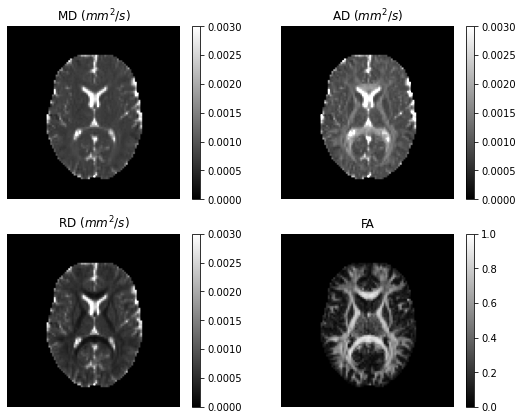

In [23]:
plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(np.rot90(MD[..., 0]), cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("MD $(mm^2/s)$")

plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(np.rot90(AD[..., 0]), cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("AD $(mm^2/s)$")

plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(np.rot90(RD[..., 0]), cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("RD $(mm^2/s)$")

plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(np.rot90(FA[..., 0]), cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title("FA")

plt.show()

Dipy can also be used to produce a colour coded FA maps. In addition of indicating the anisotropy degree by the colour level intensity, these maps provide the information of the main direction of the diffusion tensor according to the following colour coding standard:

1) red indicates that diffusion is higher on right-left directions

2) green indicates that diffusion is higher on anterior-posterior directions

3) blue indicates that diffusion is higher on inferior-superior directions

The information about the main direction of the diffusion tensor can be retrieved from the diffusion tensor eigenvectors which is saved in "dti_fit" attribute "evecs". The colour coded FA map is produced in the following way:

Text(0.5, 1.0, 'Color coded FA')

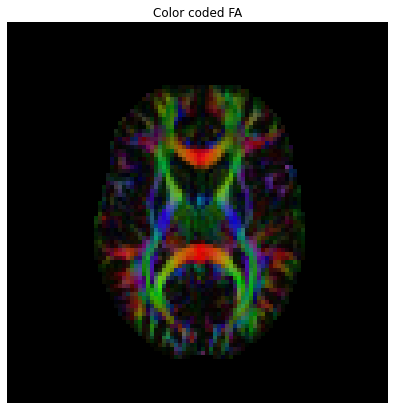

In [24]:
from dipy.reconst.dti import color_fa

FA = np.clip(FA, 0, 1)  # Just to ensure that FA values are between 0 and 1
colored_FA = color_fa(FA, dti_fit.evecs)

plt.figure(figsize=(9, 7))
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(np.rot90(colored_FA[:,:, 0]))
plt.title("Color coded FA")

### Saving data

Now that you processed the standard DTI metrics, you can saved them as NIFTI files using Dipy's save_nifti function. Here, we choose to save the DTI metrics in float32.

In [25]:
from dipy.io.image import save_nifti

save_nifti('tensor_md.nii.gz', MD.astype(np.float32), affine)
save_nifti('tensor_ad.nii.gz', AD.astype(np.float32), affine)
save_nifti('tensor_rd.nii.gz', RD.astype(np.float32), affine)
save_nifti('tensor_fa.nii.gz', FA.astype(np.float32), affine)

## Denoising images using the Marcenko-Pastur PCA algorithm
The PCA-based denoising algorithm exploits the redundancy across the diffusion-weighted images [Manjon2013](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073021), [Veraart2016a](https://pubmed.ncbi.nlm.nih.gov/27523449/). This algorithm has been shown to provide an optimal compromise between noise suppression and loss of anatomical information for different techniques such as DTI [Manjon2013](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073021), spherical deconvolution [Veraart2016a](https://pubmed.ncbi.nlm.nih.gov/27523449/) and DKI [NetoHe2018](https://www.repository.cam.ac.uk/handle/1810/281993).
For the sake of simplicity, we only select two non-zero b-values for this example.

In [26]:
import nibabel as nib

bvals = gtab.bvals
bvecs = gtab.bvecs

sel_b = np.logical_or(np.logical_or(bvals == 0, bvals == 1000), bvals == 2000)
mid_sl = data.shape[2] // 2 

gtab_sel = gradient_table(bvals[sel_b], bvecs[sel_b])

The PCA denoising using the Marcenko-Pastur distribution can be performed by calling the function "mppca" from "dipy.denoise.localpca" (this can take some time to run)

In [27]:
from dipy.denoise.localpca import mppca
from time import time

#select fraction of slices to reduce computational time
sli = 4
denoised_arr, sigma = mppca(data[:, :, mid_sl-3 : mid_sl+3, sel_b], patch_radius=2, return_sigma=True)

Internally, the mppca algorithm denoises the diffusion-weighted data using a 3D sliding window which is defined by the variable patch_radius. In total, this window should comprise a larger number of voxels than the number of diffusion-weighted volumes. Since our data has a total of 67 volumes, the patch_radius is set to 2 which corresponds to a 5x5x5 sliding window comprising a total of 125 voxels.

To assess the performance of the Marcenko-Pastur PCA denosing algorithm, an axial slice of the original data, denoised data, and residuals are plotted below:

The result saved in denoised_mppca.png


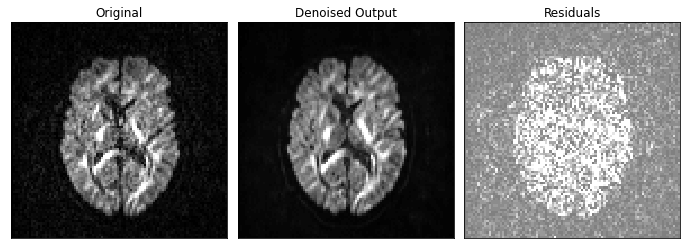

In [28]:
gra = denoised_arr.shape[3] - 1
sel_bindex=np.where(sel_b)[0]

rms_diff = np.sqrt((data[:, :, mid_sl, sel_bindex[gra]] -denoised_arr[:, :, sli, gra])** 2)

fig1, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(data[:, :, mid_sl, sel_bindex[gra]].T, cmap='gray', interpolation='none',
                  origin='lower',  vmin=0, vmax=80)
ax.flat[0].set_title('Original')
ax.flat[1].imshow(denoised_arr[:, :, sli, gra].T, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=80)
ax.flat[1].set_title('Denoised Output')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower', vmin=-10, vmax=10)
ax.flat[2].set_title('Residuals')

fig1.savefig('denoised_mppca.png')

print("The result saved in denoised_mppca.png")

Let's see how the PCA denoising algorithm affects different diffusion measurements

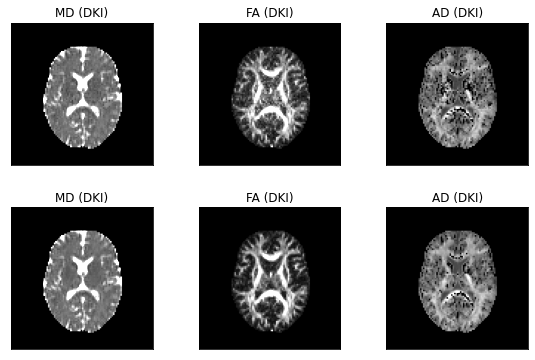

The result saved in denoised_dki.png


In [29]:
import dipy.reconst.dki as dki
dkimodel = dki.DiffusionKurtosisModel(gtab_sel)

dki_orig = dkimodel.fit(data[:, :, mid_sl-3 : mid_sl+3, sel_b], mask=mask[:, :, mid_sl-3 : mid_sl+3])
dki_den = dkimodel.fit(denoised_arr, mask=mask[:, :, mid_sl-3 : mid_sl+3])

FA_orig = dki_orig.fa
FA_den = dki_den.fa
MD_orig = dki_orig.md
MD_den = dki_den.md
MK_orig = dki_orig.mk(0, 3)
MK_den = dki_den.mk(0, 3)

fig2, ax = plt.subplots(2, 3, figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.03)

ax.flat[0].imshow(MD_orig[:, :, sli].T, cmap='gray', vmin=0, vmax=2.0e-3,
                  origin='lower')
ax.flat[0].set_title('MD (DKI)')
ax.flat[1].imshow(FA_orig[:, :, sli].T, cmap='gray', vmin=0, vmax=0.7,
                  origin='lower')
ax.flat[1].set_title('FA (DKI)')
ax.flat[2].imshow(MK_orig[:, :, sli].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[2].set_title('AD (DKI)')
ax.flat[3].imshow(MD_den[:, :, sli].T, cmap='gray', vmin=0, vmax=2.0e-3,
                  origin='lower')
ax.flat[3].set_title('MD (DKI)')
ax.flat[4].imshow(FA_den[:, :, sli].T, cmap='gray', vmin=0, vmax=0.7,
                  origin='lower')
ax.flat[4].set_title('FA (DKI)')
ax.flat[5].imshow(MK_den[:, :, sli].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[5].set_title('AD (DKI)')
plt.show()
fig2.savefig('denoised_dki.png')

print("The result saved in denoised_dki.png")

### Noise standard deviation estimation using the Marcenko-Pastur PCA algorithm
the Marcenko-Pastur PCA algorithm can also be used to estimate the image’s noise standard deviation (std). The noise std automatically computed from the mppca function can be returned by setting the optional input parameter return_sigma to True.

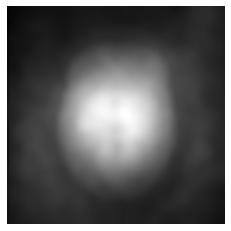

In [30]:
plt.figure('PCA Noise standard deviation estimation')
plt.imshow(sigma[..., sli].T, cmap='gray', origin='lower')
plt.axis('off')
plt.show()

The above figure shows that the Marcenko-Pastur PCA algorithm computes a 3D spatial varying noise level map. To obtain the mean noise std across all voxels, you can use the following lines of code:

In [31]:
mean_sigma = np.mean(sigma[mask[:, :, mid_sl-3 : mid_sl+3]])

Below we use this mean noise level estimate to compute the data’s nominal SNR (i.e. SNR at b-value=0):

In [32]:
b0 = denoised_arr[..., 0]

mean_signal = np.mean(b0[mask[:, :, mid_sl-3 : mid_sl+3]])

snr = mean_signal / mean_sigma

print(snr)

34.06797226874096


### Suppressing Gibbs oscillations
Magnetic Resonance (MR) images are reconstructed from the Fourier coefficients of acquired k-space images. Since only a finite number of Fourier coefficients can be acquired in practice, reconstructed MR images can be corrupted by Gibbs artefacts, which is manifested by intensity oscillations adjacent to edges of different tissues types. Although this artefact affects MR images in general, in the context of diffusion-weighted imaging, Gibbs oscillations can be magnified in derived diffusion-based estimates ([Veraart et al., 2015](https://doi.org/10.1002/mrm.25866), [Perrone et al., 2015](https://doi.org/10.1016/j.neuroimage.2015.06.068)).

In the following example, we show how to suppress Gibbs artefacts of MR images. This algorithm is based on an adapted version of a sub-voxel Gibbs suppression procedure ([Kellner et al., 2016]( https://doi.org/10.1002/mrm.26054)).

The algorithm to suppress Gibbs oscillations can be imported from the denoise module of dipy:

In [33]:
from dipy.denoise.gibbs import gibbs_removal

Let's look at another example this time.

In [34]:
from dipy.data import read_cenir_multib

bvals = [200, 1000, 2000]

img, gtab = read_cenir_multib(bvals)

data = img.get_fdata()

Gibbs oscillation suppression of all multi-shell data and all slices can be performed in the following way:

In [35]:
data_corrected = gibbs_removal(data[:, :, 40:42, :], slice_axis=2)

Due to the high dimensionality of diffusion-weighted data, we recommend that you specify which is the axis of data matrix that corresponds to different slices in the above step. This is done by using the optional parameter ‘slice_axis’.

Below we plot the results for an image acquired with b-value=0:

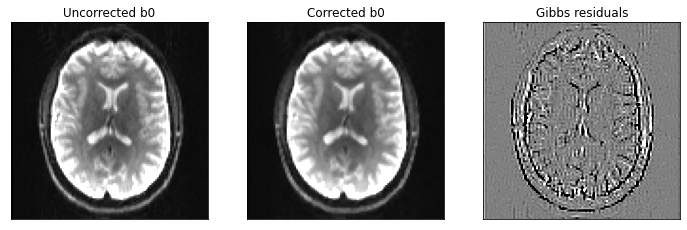

In [36]:
fig2, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(data[:, :, 40, 0].T, cmap='gray', origin='lower',
                  vmin=0, vmax=10000)
ax.flat[0].set_title('Uncorrected b0')
ax.flat[1].imshow(data_corrected[:, :, 0, 0].T, cmap='gray',
                  origin='lower', vmin=0, vmax=10000)
ax.flat[1].set_title('Corrected b0')
ax.flat[2].imshow(data_corrected[:, :, 0, 0].T - data[:, :, 40, 0].T,
                  cmap='gray', origin='lower', vmin=-500, vmax=500)
ax.flat[2].set_title('Gibbs residuals')

plt.show()
fig2.savefig('Gibbs_suppression_b0.png')

The above figure shows that the benefits of suppressing Gibbs artefacts is hard to observe on b-value=0 data. Therefore, diffusion derived metrics for both uncorrected and corrected data are computed using the mean signal diffusion kurtosis image technique.

In [37]:
# Define mean signal diffusion kurtosis model
import dipy.reconst.msdki as msdki

dki_model = msdki.MeanDiffusionKurtosisModel(gtab)

# Create a brain mask
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data[:, :, 40:42, :], vol_idx=range(10, 50),
                             median_radius=7, numpass=1, autocrop=False,
                             dilate=2)
# Fit the uncorrected data
dki_fit = dki_model.fit(data[:, :, 40:42, :], mask=mask)
MSKini = dki_fit.msk

# Fit the corrected data
dki_fit = dki_model.fit(data_corrected, mask=mask)
MSKgib = dki_fit.msk

Let’s plot the results:

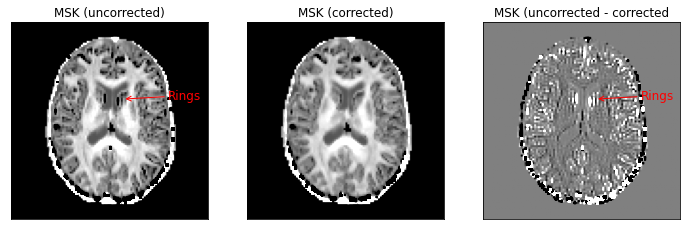

In [38]:
fig3, ax = plt.subplots(1, 3, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(MSKini[:, :, 0].T, cmap='gray', origin='lower',
                  vmin=0, vmax=1.5)
ax.flat[0].set_title('MSK (uncorrected)')
ax.flat[0].annotate('Rings', fontsize=12, xy=(59, 63),
                    color='red',
                    xycoords='data', xytext=(45, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

ax.flat[1].imshow(MSKgib[:, :, 0].T, cmap='gray', origin='lower',
                  vmin=0, vmax=1.5)
ax.flat[1].set_title('MSK (corrected)')

ax.flat[2].imshow(MSKgib[:, :, 0].T - MSKini[:, :, 0].T, cmap='gray',
                  origin='lower', vmin=-0.2, vmax=0.2)
ax.flat[2].set_title('MSK (uncorrected - corrected')
ax.flat[2].annotate('Rings', fontsize=12, xy=(59, 63),
                    color='red',
                    xycoords='data', xytext=(45, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

plt.show()
fig3.savefig('Gibbs_suppression_msdki.png')